In [1]:
import gym
import pylab
import random
import numpy as np
from collections import deque

import tflearn

import tqdm

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import adagrad, adam

Using TensorFlow backend.


In [3]:
# fix for GPU mem
import keras.backend.tensorflow_backend as KTF
import os 
import tensorflow as tf

def get_session(gpu_fraction=0.3):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


KTF.set_session(get_session())

In [4]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

## Task: fill empty spaces in the following agent code

In [5]:
# class DeepQAgent:
#     def __init__(self, state_size, action_size, render=True):
#         # Tip: if you are training this on AWS the best way is to turn off rendering
#         # and load it later with the serialized model
#         self.render = render
#         self.state_size = state_size
#         self.action_size = action_size

#         self.discount_factor = 0.99
#         self.learning_rate = 0.001
#         self.epsilon = 1.0
#         self.epsilon_min = 0.005
#         self.epsilon_decay = (self.epsilon - self.epsilon_min) / 50000
#         self.batch_size = 64
#         self.train_start = 1000
#         # replay memory
#         self.memory = deque(maxlen=20000)

#         self.model = self.build_model()
#         self.target_model = self.build_model()
#         self.update_target_model()

#     def build_model(self):
#         # Use tflearn to get simple NN for deep q-learning
#         # Spoler alert: a couple of fully connected hidden layers should be enough
#         # Output layer should have the same dimensionality as the action space

#         model = Sequential()
        
#         model.add(Dense(16, activation='relu', input_dim = self.state_size))
#         model.add(Dense(16, activation='relu'))
#         model.add(Dense(16, activation='relu'))
#         model.add(Dense(self.action_size, activation='linear'))
        
#         model.compile(adagrad(lr=self.learning_rate), 'mse')
#         return model
    

#     def update_target_model(self):
#         """Update your target model to the model you are currently learning at regular time intervals"""
#         self.target_model.set_weights(self.model.get_weights())

#     def get_action(self, state):
#         """The choice of action uses the epsilon-greedy policy for the current network."""
#         if np.random.rand() <= self.epsilon:
#             return random.randrange(self.action_size)
#         else:
#             q_value = self.model.predict(state)
#             return np.argmax(q_value[0])

#     def replay_memory(self, state, action, reward, next_state, done):
#         """Save <s, a, r, s'> to replay_memory"""
#         if action == 2:
#             action = 1
#         self.memory.append([state, action, reward, next_state, done])
#         if self.epsilon > self.epsilon_min:
#             self.epsilon -= self.epsilon_decay

#     def train_replay(self):
#         """Random samplin            if action == 0:
#                 fake_action = 0
#             elif action == 1:
#                 fake_action = 2g of batch_size samples from replay memory"""
#         if len(self.memory) < self.train_start:
#             return
#         batch_size = min(self.batch_size, len(self.memory))
#         mini_batch = random.sample(self.memory, batch_size)

#         update_input = np.zeros((batch_size, self.state_size))
#         update_target = np.zeros((batch_size, self.action_size))

#         for i in range(batch_size):
#             state, action, reward, next_state, done = mini_batch[i]
#             target = self.model.predict(state)[0]

#             # As in queuing, it gets the maximum Q Value at s'. However, it is imported from the target model.
#             target[action] = reward
            
# #             if done:
# #                 target[action] = reward
# #             else:
# #                 target[action] = reward + self.discount_factor * \
# #                                           np.amax(self.target_model.predict(next_state)[0])
#             update_input[i] = state
#             update_target[i] = target

#         # You can create a minibatch of the correct target answer and the current value of your own,
#         self.model.fit(update_input, update_target, batch_size=batch_size, epochs=1, verbose=0)

#     def load_model(self, name):
#         self.model.load_model(name)

#     def save_model(self, name):
#         self.model.save(name)

In [6]:
class DeepQAgent:
    def __init__(self, state_size, action_size, render=True):
        # Tip: if you are training this on AWS the best way is to turn off rendering
        # and load it later with the serialized model
        self.render = render
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / 50000
        self.batch_size = 64
        self.train_start = 1000
        # replay memory
        self.memory = deque(maxlen=10000)
        
        self.layer_names = self._get_layers_names()
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()
        
        
        tflearn.init_graph(gpu_memory_fraction=0.3)

    def _get_layers_names(self):
        return ['fc_1', 'fc_2', 'fc_3']
        
        
    def build_model(self):
        # Use tflearn to get simple NN for deep q-learning
        # Spoler alert: a couple of fully connected hidden layers should be enough
        # Output layer should have the same dimensionality as the action space
        # TODO
               
        model = Sequential()
        
        model.add(Dense(64, activation='relu', input_dim = self.state_size))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(adam(lr=self.learning_rate), 'mse')
        
        return model
    
    def update_target_model(self):
        """Update your target model to the model you are currently learning at regular time intervals"""
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        """The choice of action uses the epsilon-greedy policy for the current network."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def replay_memory(self, state, action, reward, next_state, done):
        """Save <s, a, r, s'> to replay_memory"""
        if action == 2:
            action = 1
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
            # print(len(self.memory))

    def train_replay(self):
        """Random sampling of batch_size samples from replay memory"""
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.action_size))

        for i in range(batch_size):
            state, action, reward, next_state, done = mini_batch[i]
            target = self.model.predict(state)[0]

            # As in queuing, it gets the maximum Q Value at s'. However, it is imported from the target model.
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.discount_factor * \
                                          np.amax(self.target_model.predict(next_state)[0])
            update_input[i] = state
            update_target[i] = target

        # You can create a minibatch of the correct target answer and the current value of your own,
        self.model.fit(update_input, update_target, batch_size=batch_size, epochs=1, verbose=0)

    def load_model(self, name):
        # TODO
        self.model.load_model(name)

    def save_model(self, name):
        # TODO
        self.model.save(name)


In [ ]:
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0] # should be equal 2
ACTION_SIZE = 2
agent = DeepQAgent(state_size, ACTION_SIZE, render=False)
# agent.load_model("./save_model/<your_saved_model_name>")
scores, episodes = [], []
N_EPISODES = 4000

<IPython.core.display.Javascript object>


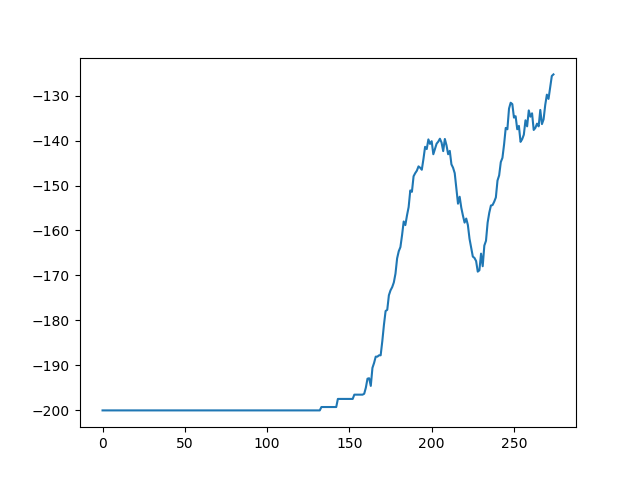

Widget Javascript not detected.  It may not be installed or enabled properly.


episode: 0   score: -200.0   memory length: 200   epsilon: 0.9960200000000077
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9920400000000154
episode: 2   score: -200.0   memory length: 600   epsilon: 0.988060000000023
episode: 3   score: -200.0   memory length: 800   epsilon: 0.9840800000000307
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.9801000000000384
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.9761200000000461
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.9721400000000537
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.9681600000000614
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.9641800000000691
episode: 9   score: -200.0   memory length: 2000   epsilon: 0.9602000000000768
episode: 10   score: -200.0   memory length: 2200   epsilon: 0.9562200000000844
episode: 11   score: -200.0   memory length: 2400   epsilon: 0.9522400000000921
episode: 12   score: -200.0   memory length: 2600   eps

episode: 103   score: -200.0   memory length: 10000   epsilon: 0.5860800000007984
episode: 104   score: -200.0   memory length: 10000   epsilon: 0.5821000000008061
episode: 105   score: -200.0   memory length: 10000   epsilon: 0.5781200000008138
episode: 106   score: -200.0   memory length: 10000   epsilon: 0.5741400000008214
episode: 107   score: -200.0   memory length: 10000   epsilon: 0.5701600000008291
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.5661800000008368
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.5622000000008445
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.5582200000008521
episode: 111   score: -200.0   memory length: 10000   epsilon: 0.5542400000008598
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.5502600000008675
episode: 113   score: -200.0   memory length: 10000   epsilon: 0.5462800000008752
episode: 114   score: -200.0   memory length: 10000   epsilon: 0.5423000000008829
episode: 115   s

episode: 203   score: -136.0   memory length: 10000   epsilon: 0.20925360000077103
episode: 204   score: -135.0   memory length: 10000   epsilon: 0.20656710000077247
episode: 205   score: -135.0   memory length: 10000   epsilon: 0.2038806000007739
episode: 206   score: -126.0   memory length: 10000   epsilon: 0.20137320000077524
episode: 207   score: -200.0   memory length: 10000   epsilon: 0.19739320000077737
episode: 208   score: -131.0   memory length: 10000   epsilon: 0.19478630000077876
episode: 209   score: -123.0   memory length: 10000   epsilon: 0.19233860000078007
episode: 210   score: -116.0   memory length: 10000   epsilon: 0.1900302000007813
episode: 211   score: -120.0   memory length: 10000   epsilon: 0.18764220000078258
episode: 212   score: -167.0   memory length: 10000   epsilon: 0.18431890000078435
episode: 213   score: -144.0   memory length: 10000   epsilon: 0.18145330000078588
episode: 214   score: -130.0   memory length: 10000   epsilon: 0.17886630000078726
episod

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

score_hist = list()

for e in tqdm.tnrange(N_EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
#     print(state)

    # Action 0 (left), 1 (do nothing), 3 (declare fake_action to avoid doing nothing
    fake_action = 0

    # Counter for the same action 4 times
    action_count = 0

    while not done:
        if agent.render:
            env.render()

        # Select an action in the current state and proceed to a step
        action_count = action_count + 1

        if action_count == 4:
            action = agent.get_action(state)
            action_count = 0

            if action == 0:
                fake_action = 0
            elif action == 1:
                fake_action = 2

        # Take 1 step with the selected action
        next_state, reward, done, info = env.step(fake_action)
        next_state = np.reshape(next_state, [1, state_size])
        # Give a penalty of -100 for actions that end an episode
        # reward = reward if not done else -100

        # Save <s, a, r, s'> to replay memory
        agent.replay_memory(state, fake_action, reward, next_state, done)
        # Continue to learn every time step
        agent.train_replay()
        score += reward
        state = next_state


        if done:
            env.reset()
            # Copy the learning model for each episode to the target model
            agent.update_target_model()

            # For each episode, the time step where cartpole stood is plot
            scores.append(score)
            episodes.append(e)
            print("episode:", e, "  score:", score, "  memory length:", len(agent.memory),
                  "  epsilon:", agent.epsilon)
            score_hist.append(score)
    
    if len(score_hist) > 20:
        mean_score = np.mean(rolling_window(np.array(score_hist), 20), axis=1)
        ax.clear()
        ax.plot(mean_score)
        fig.canvas.draw() 
    
    # Save model for every 50 episodes
    if e % 50 == 0:
        agent.save_model("save_model/vladcar.bin")